In [1]:
import sys
sys.path.append('/Users/pschulam/Git/mypy')

In [237]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nips15
import online
from sklearn import linear_model
from sklearn.cross_validation import KFold
from scipy.misc import logsumexp
%matplotlib inline

In [345]:
folds_dir = 'models/jmlr/folds'

def load_model(marker, fold, folds_dir=folds_dir):
    param_dir = os.path.join(folds_dir, marker, '{:02d}'.format(fold), 'param')
    return nips15.NipsModel.from_directory(param_dir)

def get_posteriors(model, data, censor=None):
    if censor is None:
        P = [model.posterior(*d.unpack()) for d in data]
    else:
        P = [model.posterior(*d.truncate(censor).unpack()) for d in data]
        
    return np.array(P)

def get_likel_posteriors(model, data, censor=None):
    if censor is None:
        LL = [model.likelihood(*d.unpack()) for d in data]
    else:
        LL = [model.likelihood(*d.truncate(censor).unpack()) for d in data]
        
    Z = logsumexp(LL, axis=1)
    P = np.exp(LL - Z[:, np.newaxis])
    return P

In [4]:
pfvc_spec = {'t' : 'years_seen_full',
             'y' : 'pfvc',
             'x1': ['female', 'afram'],
             'x2': ['female', 'afram', 'aca', 'scl']}

pfvc    = pd.read_csv('data/benchmark_pfvc.csv')
pfvc_pd = [nips15.PatientData.from_tbl(tbl, **pfvc_spec) for _, tbl in pfvc.groupby('ptid')]

tss_spec = {'t' : 'years_seen',
            'y' : 'tss',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

tss = pd.read_csv('data/benchmark_tss.csv')
tss_match = ['ptid'] + tss_spec['x1']
tss = pd.merge(pfvc[tss_match], tss, 'left', tss_match)
tss_pd = [nips15.PatientData.from_tbl(tbl, **tss_spec) for _, tbl in tss.groupby('ptid')]

pdlco_spec = {'t' : 'years_seen',
              'y' : 'pdlco',
              'x1': ['female', 'afram'],
              'x2': ['female', 'afram']}

pdlco = pd.read_csv('data/benchmark_pdc.csv')
pdlco_match = ['ptid'] + pdlco_spec['x1']
pdlco = pd.merge(pfvc[pdlco_match], pdlco, 'left', pdlco_match)
pdlco_pd = [nips15.PatientData.from_tbl(tbl, **pdlco_spec) for _, tbl in pdlco.groupby('ptid')]

pv1_spec = {'t' : 'years_seen',
            'y' : 'pfev1',
            'x1': ['female', 'afram'],
            'x2': ['female', 'afram']}

pv1 = pd.read_csv('data/benchmark_pv1.csv')
pv1_match = ['ptid'] + pv1_spec['x1']
pv1 = pd.merge(pfvc[pv1_match], pv1, 'left', pv1_match)
pv1_pd = [nips15.PatientData.from_tbl(tbl, **pv1_spec) for _, tbl in pv1.groupby('ptid')]

In [5]:
get_ptids = lambda pd: [p.ptid for p in pd]
pfvc_df   = pd.DataFrame({'ptid': get_ptids(pfvc_pd),  'pfvc' : pfvc_pd}).set_index('ptid')
tss_df    = pd.DataFrame({'ptid': get_ptids(tss_pd),   'tss'  : tss_pd}).set_index('ptid')
pdlco_df  = pd.DataFrame({'ptid': get_ptids(pdlco_pd), 'pdlco': pdlco_pd}).set_index('ptid')
pv1_df    = pd.DataFrame({'ptid': get_ptids(pv1_pd),   'pv1'  : pdlco_pd}).set_index('ptid')

In [6]:
folds_df = pfvc.loc[:, ['ptid', 'fold']].drop_duplicates().set_index('ptid')

In [7]:
patient_data = pd.concat([folds_df, pfvc_df, tss_df, pdlco_df, pv1_df], axis=1, join='inner')

In [8]:
model_names = ['pfvc', 'tss', 'pdc', 'pv1']
col_names   = ['pfvc', 'tss', 'pdlco', 'pv1']

In [9]:
folds = [k + 1 for k in range(10)]

In [240]:
P  = np.zeros((patient_data.shape[0], 8))
Q  = np.zeros_like(P)
Qp = np.zeros_like(P)
Ql = np.zeros_like(P)

In [241]:
censor = 1.0

for k in folds:
    models = [load_model(n, k) for n in model_names]
    test   = patient_data['fold'].values == k
    
    P[test, :]  = get_posteriors(models[0], patient_data['pfvc'][test])
    Q[test, :]  = get_posteriors(models[0], patient_data['pfvc'][test], censor)
    Qp[test, :] = np.array([models[0].prior(*d.truncate(censor).unpack()) for d in patient_data['pfvc'][test]])
    Ql[test, :] = np.array([models[0].likelihood(*d.truncate(censor).unpack()) for d in patient_data['pfvc'][test]])

In [242]:
ztrue = np.argmax(P, axis=1)
zpred = np.argmax(Q, axis=1)

In [243]:
confusion_matrix(ztrue, zpred)

array([[ 35,   6,   2,   1,   0,   0,   0,   0],
       [  3, 109,  26,  12,   0,   1,   2,   1],
       [  3,  13,  58,   3,   0,   0,   4,   0],
       [  1,  18,  18,  35,   5,   6,  14,   0],
       [  0,   1,   1,   7,  56,  10,  14,   6],
       [  0,   0,   1,   1,  23,  34,   4,   5],
       [  0,   2,   8,  11,  16,  10,  42,   0],
       [  0,   0,   0,   2,   3,   3,   1,  35]])

In [244]:
mismatched_pairs = ['{}->{}'.format(zt+1, zp+1) for zt, zp in zip(ztrue, zpred) if not zt == zp]

In [245]:
from collections import Counter
counts = Counter(mismatched_pairs)

In [246]:
counts.most_common(10)

[('2->3', 26),
 ('6->5', 23),
 ('4->3', 18),
 ('4->2', 18),
 ('7->5', 16),
 ('5->7', 14),
 ('4->7', 14),
 ('3->2', 13),
 ('2->4', 12),
 ('7->4', 11)]

In [353]:
symmetric_mismatches = ['{}<-->{}'.format(min(zt, zp) + 1, max(zt, zp) + 1) for zt, zp in zip(ztrue, zpred) if not zt == zp]

In [355]:
Counter(symmetric_mismatches).most_common(20)

[('2<-->3', 39),
 ('5<-->6', 33),
 ('2<-->4', 30),
 ('5<-->7', 30),
 ('4<-->7', 25),
 ('3<-->4', 21),
 ('6<-->7', 14),
 ('4<-->5', 12),
 ('3<-->7', 12),
 ('1<-->2', 9),
 ('5<-->8', 9),
 ('6<-->8', 8),
 ('4<-->6', 7),
 ('1<-->3', 5),
 ('2<-->7', 4),
 ('1<-->4', 2),
 ('4<-->8', 2),
 ('2<-->6', 1),
 ('3<-->5', 1),
 ('7<-->8', 1)]

In [339]:
def normalize(x, precision=2):
    y = x / x.sum()
    return np.round(y, precision)

In [350]:
P_tss = np.zeros((patient_data.shape[0], 4))
Q_tss = np.zeros_like(P_tss)

for k in folds:
    models = [load_model(n, k) for n in model_names]
    test = patient_data['fold'].values == k
    
    P_tss[test, :] = get_posteriors(models[1], patient_data['tss'][test])
    Q_tss[test, :] = get_posteriors(models[1], patient_data['tss'][test], censor)
    
ztrue_tss = np.argmax(P_tss, axis=1)
zpred_tss = np.argmax(Q_tss, axis=1)

high_skin = (zpred_tss < 2).astype(np.int)

In [351]:
confusion_matrix(ztrue_tss, zpred_tss)

array([[ 40,  23,   6,   7],
       [ 27, 153,   6,   4],
       [  0,   2, 287,   6],
       [  3,   5,   8,  95]])

In [347]:
confusion_matrix(ztrue_tss, zpred_tss)

array([[ 51,  18,   2,   5],
       [ 54, 133,   0,   3],
       [ 34,   1, 202,  58],
       [ 16,   5,  39,  51]])

In [352]:
confusion_matrix((ztrue_tss < 2).astype(np.int), (zpred_tss < 2).astype(np.int))

array([[396,  10],
       [ 23, 243]])

In [349]:
confusion_matrix((ztrue_tss < 2).astype(np.int), (zpred_tss < 2).astype(np.int))

array([[350,  56],
       [ 10, 256]])

In [348]:
pd.crosstab(high_skin, zpred + 1).apply(normalize, axis=0)

col_0,1,2,3,4,5,6,7,8
row_0,,,,,,,,
0,0.6,0.64,0.41,0.61,0.5,0.52,0.48,0.53
1,0.4,0.36,0.59,0.39,0.5,0.48,0.52,0.47


In [330]:
P_pdlco = np.zeros((patient_data.shape[0], 6))
Q_pdlco = np.zeros_like(P_pdlco)

for k in folds:
    models = [load_model(n, k) for n in model_names]
    test = patient_data['fold'].values == k
    
    P_pdlco[test, :] = get_posteriors(models[2], patient_data['pdlco'][test])
    Q_pdlco[test, :] = get_posteriors(models[2], patient_data['pdlco'][test], censor)
    
ztrue_pdlco = np.argmax(P_pdlco, axis=1)
zpred_pdlco = np.argmax(Q_pdlco, axis=1)

def classify_pdlco(z):
    mapping = [(0, 0), (1, 0), (4, 0), (2, 1), (3, 1), (5, 2)]
    y = np.zeros_like(z)
    for m in mapping:
        i = z == m[0]
        y[i] = m[1]
    return y

pdlco_level = classify_pdlco(zpred_pdlco)

In [331]:
confusion_matrix(ztrue_pdlco, zpred_pdlco)

array([[60, 35,  3,  1,  6,  0],
       [28, 92,  4,  0, 14,  0],
       [ 0, 14, 70, 13, 24,  3],
       [ 0, 11, 29, 54, 19,  6],
       [ 3, 21, 14, 16, 54,  1],
       [ 0,  3,  3,  5,  1, 65]])

In [332]:
confusion_matrix(classify_pdlco(ztrue_pdlco), classify_pdlco(zpred_pdlco))

array([[313,  38,   1],
       [ 68, 166,   9],
       [  4,   8,  65]])

In [338]:
pd.crosstab(classify_pdlco(zpred_pdlco), zpred + 1).apply(normalize, axis=0)

col_0,1,2,3,4,5,6,7,8
row_0,,,,,,,,
0,0.93,0.75,0.76,0.57,0.37,0.23,0.60,0.09
1,0.05,0.23,0.20,0.38,0.50,0.55,0.23,0.43
2,0.02,0.01,0.04,0.06,0.14,0.22,0.16,0.49


In [341]:
P_pv1 = np.zeros((patient_data.shape[0], 4))
Q_pv1 = np.zeros_like(P_pv1)

for k in folds:
    models = [load_model(n, k) for n in model_names]
    test = patient_data['fold'].values == k
    
    P_pv1[test, :] = get_posteriors(models[3], patient_data['pv1'][test])
    Q_pv1[test, :] = get_posteriors(models[3], patient_data['pv1'][test], censor)
    
ztrue_pv1 = np.argmax(P_pv1, axis=1)
zpred_pv1 = np.argmax(Q_pv1, axis=1)

def classify_pv1(z):
    mapping = [(0, 0), (1, 0), (2, 1), (3, 1)]
    y = np.zeros_like(z)
    for m in mapping:
        i = z == m[0]
        y[i] = m[1]
    return y

pv1_level = classify_pv1(zpred_pv1)

In [342]:
confusion_matrix(ztrue_pv1, zpred_pv1)

array([[125,  35,   2,   1],
       [ 48,  58,  17,  11],
       [  9,  17, 111,  31],
       [ 17,  29,  41, 120]])

In [343]:
confusion_matrix(classify_pv1(ztrue_pv1), classify_pv1(zpred_pv1))

array([[266,  31],
       [ 72, 303]])

In [344]:
pd.crosstab(classify_pv1(zpred_pv1), zpred + 1).apply(normalize, axis=0)

col_0,1,2,3,4,5,6,7,8
row_0,,,,,,,,
0,0.93,0.72,0.64,0.57,0.33,0.2,0.37,0.02
1,0.07,0.28,0.36,0.43,0.67,0.8,0.63,0.98


For those that are wrong, how are they wrong?

1. Is the second most likely subtype the correct one?
2. What's the difference in posterior probability?
3. Are there other subtypes that are also consistently highly ranked?

Often, the second most likely subtype is the correct one.

1. Would it be reasonable to discriminatively train each subtype against the one it's most frequently confused with?

In [ ]:
def get_misclassified_pair(key):
    zt, *_, zp = key
    zt = int(zt) - 1
    zp = int(zp) - 1
    return zt, zp

In [310]:
rank = 2
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
correct = (ztrue == zt) & (zpred == zt)
wrong = (ztrue == zt) & (zpred == zp)
np.argsort(Q[wrong, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

6 -> 5


array([[4, 6, 5],
       [6, 7, 5],
       [7, 6, 5],
       [7, 6, 5],
       [4, 6, 5],
       [7, 6, 5],
       [6, 7, 5],
       [4, 7, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [8, 6, 5],
       [7, 6, 5],
       [8, 6, 5],
       [8, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5]])

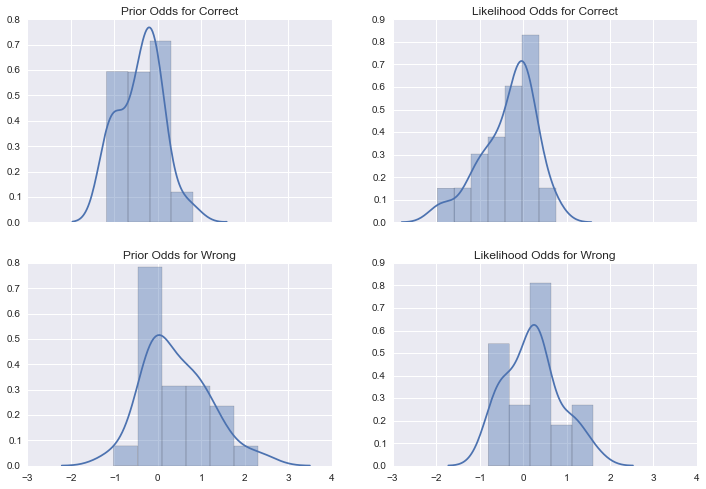

In [311]:
p_odds_correct = np.round(Qp[correct, zp] - Qp[correct, zt], 2)[:, np.newaxis]
p_odds_wrong   = np.round(Qp[wrong, zp] - Qp[wrong, zt], 2)[:, np.newaxis]
l_odds_correct = np.round(Ql[correct, zp] - Ql[correct, zt], 2)[:, np.newaxis]
l_odds_wrong   = np.round(Ql[wrong, zp] - Ql[wrong, zt], 2)[:, np.newaxis]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 8))

_ = ax[0, 0].set_title('Prior Odds for Correct')
_ = sns.distplot(p_odds_correct, ax=ax[0, 0])

_ = ax[1, 0].set_title('Prior Odds for Wrong')
_ = sns.distplot(p_odds_wrong  , ax=ax[1, 0])

_ = ax[0, 1].set_title('Likelihood Odds for Correct')
_ = sns.distplot(l_odds_correct, ax=ax[0, 1])

_ = ax[1, 1].set_title('Likelihood Odds for Wrong')
_ = sns.distplot(l_odds_wrong  , ax=ax[1, 1])

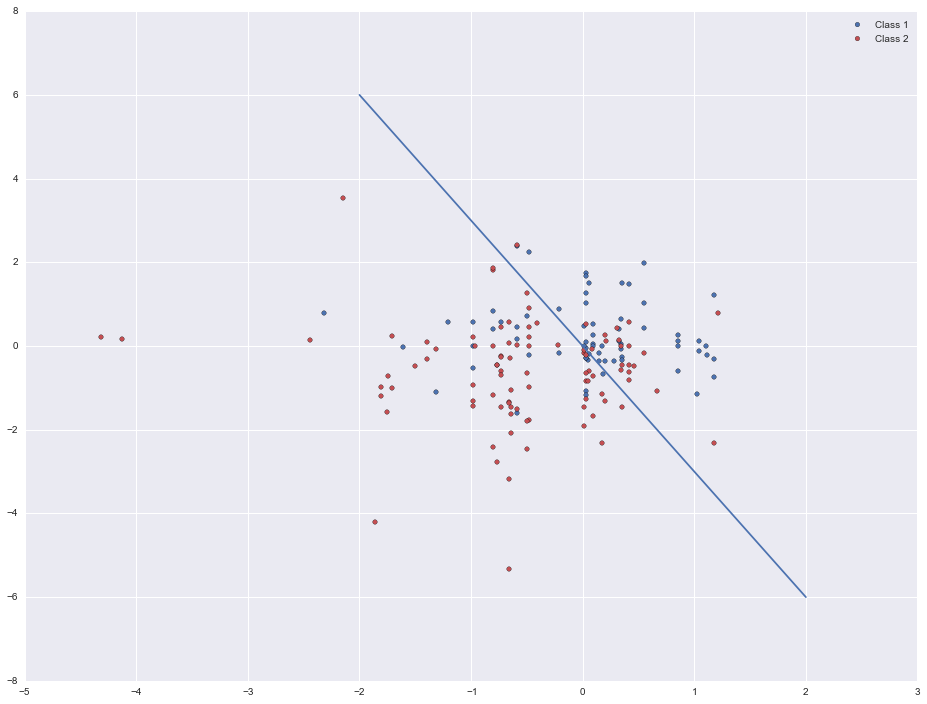

In [313]:
z1 = zt
z2 = zp

Qp1 = Qp[ztrue == z1, z1] - Qp[ztrue == z1, z2]
Ql1 = Ql[ztrue == z1, z1] - Ql[ztrue == z1, z2]

Qp2 = Qp[ztrue == z2, z1] - Qp[ztrue == z2, z2]
Ql2 = Ql[ztrue == z2, z1] - Ql[ztrue == z2, z2]

fig, ax = plt.subplots(1, figsize=(16, 12))
_ = ax.scatter(Qp1, Ql1, c=sns.color_palette()[0], label='Class 1')
_ = ax.scatter(Qp2, Ql2, c=sns.color_palette()[2], label='Class 2')
_ = ax.plot((-2, 2), (6, -6))
_ = ax.legend()

In [299]:
X1 = np.c_[Qp1, Ql1]
X2 = np.c_[Qp2, Ql2]
X  = np.r_[X1, X2]
y  = np.r_[np.ones((ztrue == z1).sum()), np.zeros((ztrue == z2).sum())]

In [303]:
((X.sum(axis=1) > 0) == y).mean()

0.79282868525896411

In [307]:
((X[:, 0] > 0) == y).mean()

0.70119521912350602

In [283]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [275]:
rank = 2
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
correct = (ztrue == zt) & (zpred == zt)
wrong = (ztrue == zt) & (zpred == zp)
np.argsort(Q[wrong, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

6 -> 5


array([[4, 6, 5],
       [6, 7, 5],
       [7, 6, 5],
       [7, 6, 5],
       [4, 6, 5],
       [7, 6, 5],
       [6, 7, 5],
       [4, 7, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [8, 6, 5],
       [7, 6, 5],
       [8, 6, 5],
       [8, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5]])

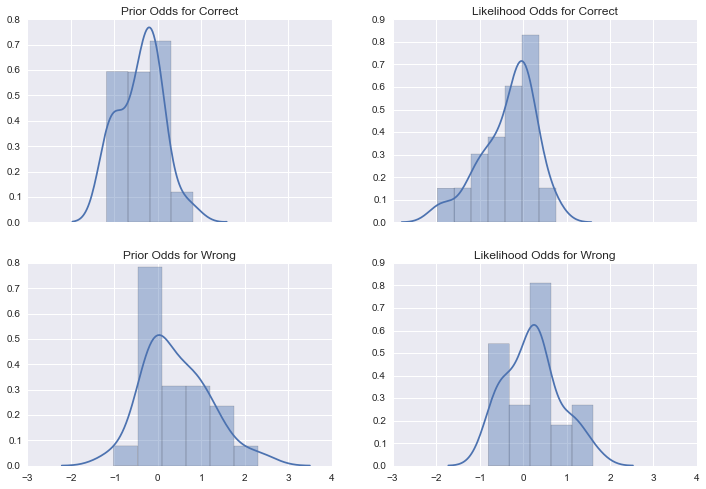

In [276]:
p_odds_correct = np.round(Qp[correct, zp] - Qp[correct, zt], 2)[:, np.newaxis]
p_odds_wrong   = np.round(Qp[wrong, zp] - Qp[wrong, zt], 2)[:, np.newaxis]
l_odds_correct = np.round(Ql[correct, zp] - Ql[correct, zt], 2)[:, np.newaxis]
l_odds_wrong   = np.round(Ql[wrong, zp] - Ql[wrong, zt], 2)[:, np.newaxis]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 8))

_ = ax[0, 0].set_title('Prior Odds for Correct')
_ = sns.distplot(p_odds_correct, ax=ax[0, 0])

_ = ax[1, 0].set_title('Prior Odds for Wrong')
_ = sns.distplot(p_odds_wrong  , ax=ax[1, 0])

_ = ax[0, 1].set_title('Likelihood Odds for Correct')
_ = sns.distplot(l_odds_correct, ax=ax[0, 1])

_ = ax[1, 1].set_title('Likelihood Odds for Wrong')
_ = sns.distplot(l_odds_wrong  , ax=ax[1, 1])

In [278]:
rank = 3
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
correct = (ztrue == zt) & (zpred == zt)
wrong = (ztrue == zt) & (zpred == zp)
np.argsort(Q[wrong, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

4 -> 3


array([[2, 4, 3],
       [4, 2, 3],
       [4, 2, 3],
       [5, 2, 3],
       [2, 4, 3],
       [7, 4, 3],
       [2, 4, 3],
       [4, 2, 3],
       [4, 2, 3],
       [4, 2, 3],
       [2, 4, 3],
       [7, 4, 3],
       [7, 2, 3],
       [4, 2, 3],
       [7, 4, 3],
       [4, 2, 3],
       [4, 2, 3],
       [4, 2, 3]])

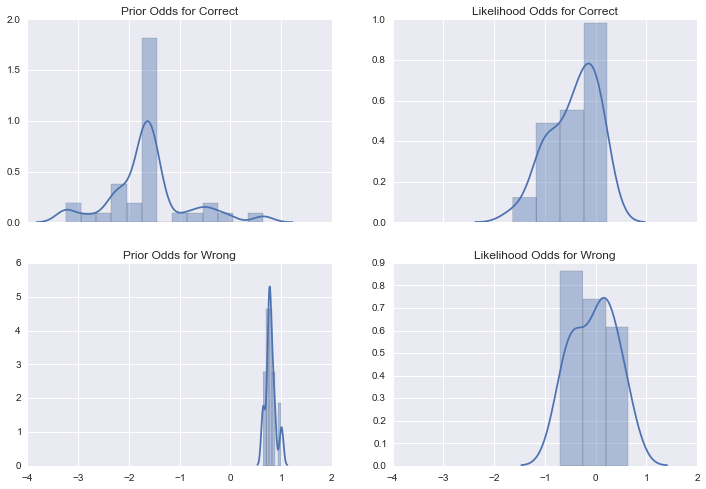

In [279]:
p_odds_correct = np.round(Qp[correct, zp] - Qp[correct, zt], 2)[:, np.newaxis]
p_odds_wrong   = np.round(Qp[wrong, zp] - Qp[wrong, zt], 2)[:, np.newaxis]
l_odds_correct = np.round(Ql[correct, zp] - Ql[correct, zt], 2)[:, np.newaxis]
l_odds_wrong   = np.round(Ql[wrong, zp] - Ql[wrong, zt], 2)[:, np.newaxis]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 8))

_ = ax[0, 0].set_title('Prior Odds for Correct')
_ = sns.distplot(p_odds_correct, ax=ax[0, 0])

_ = ax[1, 0].set_title('Prior Odds for Wrong')
_ = sns.distplot(p_odds_wrong  , ax=ax[1, 0])

_ = ax[0, 1].set_title('Likelihood Odds for Correct')
_ = sns.distplot(l_odds_correct, ax=ax[0, 1])

_ = ax[1, 1].set_title('Likelihood Odds for Wrong')
_ = sns.distplot(l_odds_wrong  , ax=ax[1, 1])

In [280]:
rank = 4
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
correct = (ztrue == zt) & (zpred == zt)
wrong = (ztrue == zt) & (zpred == zp)
np.argsort(Q[wrong, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

4 -> 2


array([[3, 4, 2],
       [7, 4, 2],
       [3, 4, 2],
       [4, 1, 2],
       [4, 3, 2],
       [3, 4, 2],
       [3, 4, 2],
       [4, 1, 2],
       [4, 1, 2],
       [7, 4, 2],
       [3, 4, 2],
       [4, 3, 2],
       [5, 4, 2],
       [7, 4, 2],
       [7, 1, 2],
       [3, 4, 2],
       [3, 4, 2],
       [4, 3, 2]])

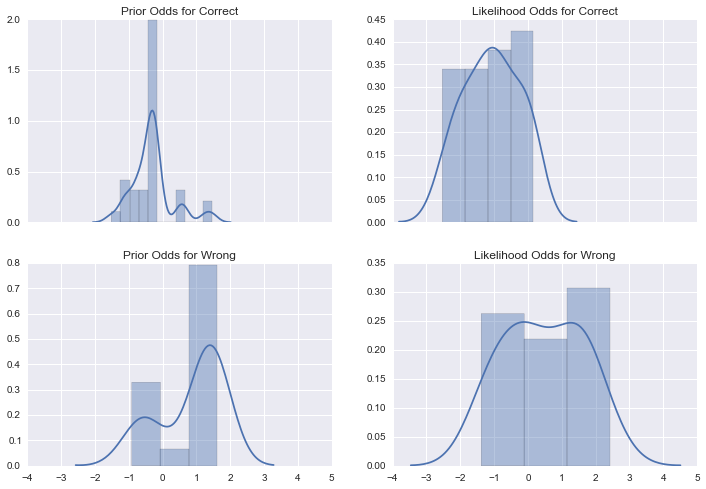

In [281]:
p_odds_correct = np.round(Qp[correct, zp] - Qp[correct, zt], 2)[:, np.newaxis]
p_odds_wrong   = np.round(Qp[wrong, zp] - Qp[wrong, zt], 2)[:, np.newaxis]
l_odds_correct = np.round(Ql[correct, zp] - Ql[correct, zt], 2)[:, np.newaxis]
l_odds_wrong   = np.round(Ql[wrong, zp] - Ql[wrong, zt], 2)[:, np.newaxis]

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 8))

_ = ax[0, 0].set_title('Prior Odds for Correct')
_ = sns.distplot(p_odds_correct, ax=ax[0, 0])

_ = ax[1, 0].set_title('Prior Odds for Wrong')
_ = sns.distplot(p_odds_wrong  , ax=ax[1, 0])

_ = ax[0, 1].set_title('Likelihood Odds for Correct')
_ = sns.distplot(l_odds_correct, ax=ax[0, 1])

_ = ax[1, 1].set_title('Likelihood Odds for Wrong')
_ = sns.distplot(l_odds_wrong  , ax=ax[1, 1])

In [215]:
np.round(Q[select, zp] - Q[select, zt], 2)

array([ 0.23,  0.29,  0.29,  0.22,  0.23,  0.21,  0.23,  0.14,  0.12,
        0.3 ,  0.33,  0.32,  0.32])

In [216]:
rank = 5
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
select = (ztrue == zt) & (zpred == zp)
np.argsort(Q[select, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

4 -> 7


array([[4, 3, 7],
       [5, 4, 7],
       [4, 3, 7],
       [5, 4, 7],
       [5, 4, 7],
       [6, 4, 7],
       [5, 4, 7],
       [5, 4, 7],
       [5, 4, 7],
       [4, 3, 7],
       [5, 6, 7],
       [3, 4, 7],
       [4, 6, 7]])

In [217]:
np.round(Q[select, zp] - Q[select, zt], 2)

array([ 0.54,  0.02,  0.14,  0.29,  0.02,  0.08,  0.02,  0.29,  0.02,
        0.32,  0.24,  0.07,  0.36])

In [218]:
rank = 6
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
select = (ztrue == zt) & (zpred == zp)
np.argsort(Q[select, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

7 -> 5


array([[4, 7, 5],
       [3, 4, 5],
       [7, 4, 5],
       [6, 7, 5],
       [7, 6, 5],
       [6, 7, 5],
       [6, 7, 5],
       [7, 6, 5],
       [7, 6, 5],
       [7, 6, 5],
       [8, 7, 5]])

In [219]:
np.round(Q[select, zp] - Q[select, zt], 2)

array([ 0.28,  0.44,  0.19,  0.24,  0.39,  0.54,  0.33,  0.2 ,  0.25,
        0.2 ,  0.22])

In [220]:
rank = 7
zt, zp = get_misclassified_pair(counts.most_common(10)[rank - 1][0])
print('{} -> {}'.format(zt + 1, zp + 1))
select = (ztrue == zt) & (zpred == zp)
np.argsort(Q[select, ])[:, -3:] + 1
#np.round(Q[select, :], 2)

4 -> 2


array([[3, 4, 2],
       [3, 4, 2],
       [4, 3, 2],
       [3, 4, 2],
       [1, 4, 2],
       [7, 4, 2],
       [4, 3, 2],
       [3, 4, 2],
       [3, 4, 2],
       [7, 4, 2],
       [3, 4, 2]])

In [221]:
np.round(Q[select, zp] - Q[select, zt], 2)

array([ 0.39,  0.51,  0.7 ,  0.22,  0.19,  0.12,  0.51,  0.29,  0.09,
        0.19,  0.24])

In [121]:
aux_num = 0
N  = P.shape[0]
XX = [Qi[:, 1:] for Qi in QQaux]
dev_folds = KFold(N, 4, shuffle=True, random_state=0)
all_clf = []
for i, (dtrain, dtest) in enumerate(dev_folds):
    y = np.argmax(P[dtrain], axis=1)
    X = XX[aux_num][dtrain]
    cv = KFold(y.size, 10, shuffle=True, random_state=0)
    clf = linear_model.LogisticRegressionCV(Cs=30, cv=cv, penalty='l2', solver='lbfgs', multi_class='multinomial')
    clf.fit(X, y)
    all_clf.append(clf)
    Qhat[aux_num][dtest, :] = clf.predict_proba(XX[aux_num][dtest])

In [122]:
from sklearn.metrics import confusion_matrix
ztrue = np.argmax(P, axis=1)
zpred = np.argmax(Qhat[aux_num], axis=1)
confusion_matrix(ztrue, zpred)

array([[  0,  36,   0,   1,   0,   0,   6,   0],
       [  0, 112,   3,   4,   0,   6,   1,   1],
       [  0,  71,   0,   3,   0,   3,   7,   0],
       [  0,  51,   1,   2,   0,   8,  10,   0],
       [  0,  46,   3,   2,   0,  12,   6,   0],
       [  0,  39,   1,   5,   0,  19,   4,   0],
       [  0,  54,   3,   5,   0,   6,   8,   2],
       [  0,  23,   0,   1,   0,  17,   9,   0]])

In [123]:
aux_num = 1
N  = P.shape[0]
XX = [Qi[:, 1:] for Qi in QQaux]
dev_folds = KFold(N, 4, shuffle=True, random_state=0)
all_clf = []
for i, (dtrain, dtest) in enumerate(dev_folds):
    y = np.argmax(P[dtrain], axis=1)
    X = XX[aux_num][dtrain]
    cv = KFold(y.size, 10, shuffle=True, random_state=0)
    clf = linear_model.LogisticRegressionCV(Cs=30, cv=cv, penalty='l2', solver='lbfgs', multi_class='multinomial')
    clf.fit(X, y)
    all_clf.append(clf)
    Qhat[aux_num][dtest, :] = clf.predict_proba(XX[aux_num][dtest])

In [124]:
from sklearn.metrics import confusion_matrix
ztrue = np.argmax(P, axis=1)
zpred = np.argmax(Qhat[aux_num], axis=1)
confusion_matrix(ztrue, zpred)

array([[  0,  38,   0,   0,   2,   0,   3,   0],
       [  0, 103,   1,   0,   8,   6,   8,   1],
       [  0,  51,   0,   0,   8,   8,  15,   2],
       [  0,  47,   0,   0,   5,   3,  14,   3],
       [  0,  23,   0,   0,  20,   6,  10,  10],
       [  0,  23,   0,   0,  13,  11,   9,  12],
       [  0,  26,   0,   0,   6,  10,  23,  13],
       [  0,   6,   0,   1,   3,   6,  10,  24]])

In [125]:
aux_num = 2
N  = P.shape[0]
XX = [Qi[:, 1:] for Qi in QQaux]
dev_folds = KFold(N, 4, shuffle=True, random_state=0)
all_clf = []
for i, (dtrain, dtest) in enumerate(dev_folds):
    y = np.argmax(P[dtrain], axis=1)
    X = XX[aux_num][dtrain]
    cv = KFold(y.size, 10, shuffle=True, random_state=0)
    clf = linear_model.LogisticRegressionCV(Cs=30, cv=cv, penalty='l2', solver='lbfgs', multi_class='multinomial')
    clf.fit(X, y)
    all_clf.append(clf)
    Qhat[aux_num][dtest, :] = clf.predict_proba(XX[aux_num][dtest])

In [128]:
from sklearn.metrics import confusion_matrix
ztrue = np.argmax(P, axis=1)
zpred = np.argmax(Qhat[aux_num], axis=1)
confusion_matrix(ztrue, zpred)

array([[ 0, 39,  0,  0,  2,  0,  2,  0],
       [ 0, 97,  3,  0, 17,  2,  7,  1],
       [ 0, 52,  1,  0, 13,  4, 14,  0],
       [ 0, 44,  3,  0, 11,  1, 12,  1],
       [ 0, 24,  1,  0, 27,  2, 12,  3],
       [ 0, 22,  2,  0, 17,  5, 20,  2],
       [ 0, 25,  2,  0, 13,  6, 23,  9],
       [ 0,  7,  1,  0,  8,  2, 27,  5]])